In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

import numpy as np

In [2]:
def v_prime(v):
    x = v[0]
    y = v[1]

    rot = np.stack((-y, x))
    out = np.stack((x, y))

    return rot + 0.2 * out

def jacobian(v, dt):
    x = v[0]
    y = v[1]

    rot_jac = np.array(
       [[0, -1],
        [1, 0]]
    )

    out_jac = np.array(
       [[1, 0],
        [0, 1]]
    )

    return np.eye(2) + dt * (rot_jac + 0.2 * out_jac)

def euler_step(v, dt):
    return v + dt * v_prime(v)

def compute_path(v, t, compute_jacs=False):
    paths = np.zeros((len(t), len(v)))
    paths[0] = v

    n = v.shape[0]

    for i in range(len(t)-1):
        paths[i+1] = euler_step(paths[i], t[i+1] - t[i])
        # cum_grad = jacobian(paths[i], t[i+1] - t[i]) @ cum_grad

    jacobians = None
    if compute_jacs:
        jacobians = np.zeros((len(t), n, n))

        jacobians[-1] = np.eye(n)
        for i in range(len(t)-2, -1, -1):
            jacobians[i] = jacobians[i+1] @ jacobian(paths[i], t[i+1] - t[i])
    
        return paths, jacobians
    return paths

v0 = np.array([-1, 1])
epsilon = 0.15
arrow_len = 0.3 / epsilon

ep_x = epsilon * np.array([1, 0])
ep_y = epsilon * np.array([0, 1])

ts = np.linspace(0, 7, 1001)
path, jacobians = compute_path(v0, ts, compute_jacs=True)
path_x = compute_path(v0 + ep_x, ts)
path_y = compute_path(v0 + ep_y, ts)


cum_grad = jacobians[0]
print(cum_grad)

[[ 3.15661749 -2.69631283]
 [ 2.69631283  3.15661749]]


Finite difference: [0.47349262 0.40444692]
Cumulative Gradient: [0.47349262 0.40444692]
Finite difference: [-0.40444692  0.47349262]
Cumulative Gradient: [-0.40444692  0.47349262]
Error = 5.987232154250471e-15


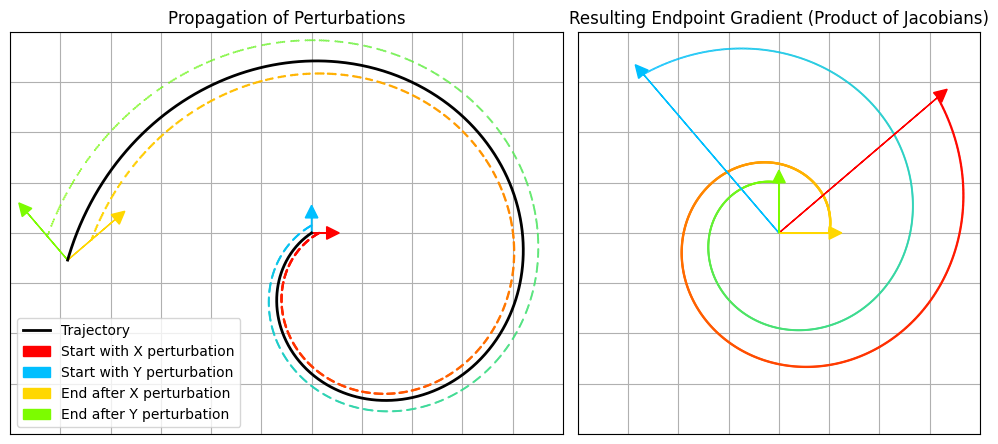

In [3]:
# Plotting
# fig, ax = plt.subplots(1,2, figsize=(15, 10), dpi=100)

fig = plt.figure(figsize=(10, 6), dpi=100)

gs = gridspec.GridSpec(1, 2, width_ratios=[11/8-0, 1])  # The first plot is twice as wide

ax1 = fig.add_subplot(gs[0])  # First subplot
ax2 = fig.add_subplot(gs[1])  # Second subplot


ax1.grid()
ax1.set_axisbelow(True)

cfrac = np.linspace(0, 1, path_x.shape[0])
cmap_x = LinearSegmentedColormap.from_list("red_to_yellow", ["red", "gold"])
cmap_y = LinearSegmentedColormap.from_list("red_to_yellow", ["deepskyblue", "lawngreen"])

def dashed_alpha(x, mod_dist=0.012, threshold=0.008):
    dists = np.concat([[0], np.linalg.norm(x[1:] - x[:-1], axis=1)])
    dists = np.cumsum(dists)
    dists = dists / np.max(dists)
    alpha = np.mod(dists, mod_dist) < threshold
    return alpha

# dists = np.concat([[0], np.linalg.norm(path[1:] - path[:-1], axis=1)])
# dists = np.cumsum(dists)
# dists = dists / np.max(dists)

# alpha = dashed_alpha(path)

ax1.plot(path[:,0], path[:,1], lw=2, color='k', alpha=1, label='Trajectory')
ax1.scatter(path_x[:,0], path_x[:,1], c=cfrac, alpha=dashed_alpha(path_x), s=0.5, cmap=cmap_x)
ax1.scatter(path_y[:,0], path_y[:,1], c=cfrac, alpha=dashed_alpha(path_y), s=0.2, cmap=cmap_y)
# ax1.plot([], [], '--', color='red', label='Path + epsilon_x')
# ax1.plot([], [], '--', color='deepskyblue', label='Path + epsilon_x')

ax1.arrow(*path[0], *(arrow_len*ep_x), color='red', head_width=0.25, head_length=0.25, label='Start with X perturbation')
ax1.arrow(*path[0], *(arrow_len*ep_y), color='deepskyblue', head_width=0.25, head_length=0.25, label='Start with Y perturbation')

ep1_x = path_x[-1] - path[-1]
ep1_y = path_y[-1] - path[-1]

ax1.arrow(*path[-1], *(arrow_len*ep1_x), color='gold', head_width=0.25, head_length=0.25, label='End after X perturbation')
ax1.arrow(*path[-1], *(arrow_len*ep1_y), color='lawngreen', head_width=0.25, head_length=0.25, label='End after Y perturbation')

ep1_x_cum = cum_grad @ ep_x
ep1_y_cum = cum_grad @ ep_y

print(f'Finite difference: {ep1_x}')
print(f'Cumulative Gradient: {ep1_x_cum}')
print(f'Finite difference: {ep1_y}')
print(f'Cumulative Gradient: {ep1_y_cum}')
print(f'Error = {np.linalg.norm(ep1_x - ep1_x_cum)}')

# ax1.arrow(*(path[-1]), *(arrow_len*ep1_x_cum), color='g', head_width=0.125, head_length=0.125)
# ax1.arrow(*(path[-1]), *(arrow_len*ep1_y_cum), color='g', head_width=0.125, head_length=0.125)

ax1.tick_params(
    axis='both',       # x and y axis
    which='both',      # major and minor ticks
    bottom=False,      # remove bottom ticks
    top=False,         # remove top ticks
    left=False,        # remove left ticks
    right=False,       # remove right ticks
    labelbottom=False, # remove x-axis numbers
    labelleft=False    # remove y-axis numbers
)


ax1.set_aspect('equal')
ax1.set_xticks(np.arange(-7, 4, 1))
ax1.set_yticks(np.arange(-5, 6, 1))
ax1.set_xlim(-7, 4)
ax1.set_ylim(-3, 5)
ax1.legend(loc='lower left')
ax1.set_title('Propagation of Perturbations')

# Plotting Jacobians

ax2.scatter(jacobians[:, 0, 0], jacobians[:, 1, 0], c=cfrac, alpha=dashed_alpha(jacobians[:,:,0], threshold=1), s=0.5, cmap=cmap_x)
ax2.scatter(jacobians[:, 0, 1], jacobians[:, 1, 1], c=cfrac, alpha=dashed_alpha(jacobians[:,:,1], threshold=1), s=0.2, cmap=cmap_y)


ax2.arrow(0, 0, *jacobians[0,:,0], color='red', head_width=0.25, head_length=0.25, label='Start with X perturbation')
ax2.arrow(0, 0, *jacobians[0,:,1], color='deepskyblue', head_width=0.25, head_length=0.25, label='Start with Y perturbation')

ax2.arrow(0, 0, *jacobians[-1,:,0], color='gold', head_width=0.25, head_length=0.25, label='Start with X perturbation')
ax2.arrow(0, 0, *jacobians[-1,:,1], color='lawngreen', head_width=0.25, head_length=0.25, label='Start with Y perturbation')

ax2.set_aspect('equal')
ax2.set_xlim(-4, 4)
ax2.set_ylim(-4, 4)
ax2.tick_params(
    axis='both',       # x and y axis
    which='both',      # major and minor ticks
    bottom=False,      # remove bottom ticks
    top=False,         # remove top ticks
    left=False,        # remove left ticks
    right=False,       # remove right ticks
    labelbottom=False, # remove x-axis numbers
    labelleft=False    # remove y-axis numbers
)
ax2.grid()
ax2.set_axisbelow(True)
ax2.set_title('Resulting Endpoint Gradient (Product of Jacobians)')


plt.tight_layout()
# plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.05)
plt.show()

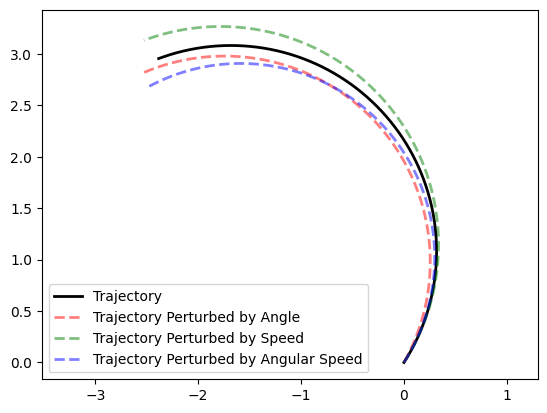

Finite difference: [-0.17285102 -0.1482562   0.06        0.          0.        ]
Cumulative Gradient: [-0.17724685 -0.14302619  0.06        0.          0.        ]
Finite difference: [-0.14302619  0.17724685  0.          0.06        0.        ]
Cumulative Gradient: [-0.14302619  0.17724685  0.          0.06        0.        ]
Finite difference: [-0.12166952 -0.28585902  0.15        0.          0.03      ]
Cumulative Gradient: [-0.13789281 -0.2823758   0.15        0.          0.03      ]
Error = 0.006832006088960795
Error = 8.601721120304417e-15
Error = 0.016593007085442493
[[ 1.          0.         -2.95411417 -2.38376985 -4.59642686]
 [ 0.          1.         -2.38376985  2.95411417 -9.41252669]
 [ 0.          0.          1.          0.          5.        ]
 [ 0.          0.          0.          1.          0.        ]
 [ 0.          0.          0.          0.          1.        ]]


In [25]:
def v_prime_components(v, dt):
    x = v[0]    # x coordinate
    y = v[1]    # y coordinate
    a = v[2]    # angle
    s = v[3]    # speed
    w = v[4]    # angular speed

    A1 = np.array([x, y, a, s, w])
    A2 = np.array([s * np.cos(a), s * np.sin(a), w, 0, 0])
    A = A1 + dt*A2

    dt2 = dt*dt/2

    return A

def jacobian_components(v, dt):
    x = v[0]    # x coordinate
    y = v[1]    # y coordinate
    a = v[2]    # angle
    s = v[3]    # speed
    w = v[4]    # angular speed

    J_A1 = np.eye(5)
    J_A2 = np.array(
       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [-s*np.sin(a), s*np.cos(a), 0, 0, 0],
        [np.cos(a), np.sin(a), 0, 0, 0],
        [0, 0, 1, 0, 0]]
    ).T

    J_A = J_A1 + dt*J_A2

    return J_A

def euler_step2(v, dt):
    A = v_prime_components(v, dt)
    return A

def compute_path(v, t, compute_jacs=False):
    paths = np.zeros((len(t), len(v)))
    paths[0] = v

    n = v.shape[0]

    for i in range(len(t)-1):
        A = euler_step2(paths[i], t[i+1] - t[i])
        paths[i+1] = A

    jacobians = None
    if compute_jacs:
        jacobians = np.zeros((len(t), n, n))

        jacobians[-1] = np.eye(n)
        for i in range(len(t)-2, -1, -1):
            J_A = jacobian_components(paths[i], t[i+1] - t[i])
            jacobians[i] = jacobians[i+1] @ J_A
    
        return paths, jacobians
    return paths

v0 = np.array([0, 0, 1, 1, 0.5])
epsilon = 0.03
arrow_len = 0.3 / epsilon

ep_a = epsilon * np.array([0, 0, 2, 0, 0])
ep_s = epsilon * np.array([0, 0, 0, 2, 0])
ep_w = epsilon * np.array([0, 0, 0, 0, 1])

dt_max = 0.001
t0 = 0
t1 = 5
n_ts = int((t1 - t0) / dt_max)
ts = np.linspace(t0, t1, n_ts)


path, jacobians = compute_path(v0, ts, compute_jacs=True)
path_a = compute_path(v0 + ep_a, ts)
path_s = compute_path(v0 + ep_s, ts)
path_w = compute_path(v0 + ep_w, ts)

plt.plot(path[:,0], path[:,1], lw=2, color='k', alpha=1, label='Trajectory')
plt.plot(path_a[:,0], path_a[:,1], '--', lw=2, color='r', alpha=0.5, label='Trajectory Perturbed by Angle')
plt.plot(path_s[:,0], path_s[:,1], '--', lw=2, color='g', alpha=0.5, label='Trajectory Perturbed by Speed')
plt.plot(path_w[:,0], path_w[:,1], '--', lw=2, color='b', alpha=0.5, label='Trajectory Perturbed by Angular Speed')
plt.axis('equal')
plt.legend(loc='lower left')
plt.show()


ep1_a = path_a[-1] - path[-1]
ep1_s = path_s[-1] - path[-1]
ep1_w = path_w[-1] - path[-1]
ep1_a_cum = jacobians[0] @ ep_a
ep1_s_cum = jacobians[0] @ ep_s
ep1_w_cum = jacobians[0] @ ep_w



# Research Affine Transformations
# Linear approximation is good for very small epsilons



print(f'Finite difference: {ep1_a}')
print(f'Cumulative Gradient: {ep1_a_cum}')
print(f'Finite difference: {ep1_s}')
print(f'Cumulative Gradient: {ep1_s_cum}')
print(f'Finite difference: {ep1_w}')
print(f'Cumulative Gradient: {ep1_w_cum}')

print(f'Error = {np.linalg.norm(ep1_a - ep1_a_cum)}')
print(f'Error = {np.linalg.norm(ep1_s - ep1_s_cum)}')
print(f'Error = {np.linalg.norm(ep1_w - ep1_w_cum)}')

print(jacobians[0])